In [ ]:
import numpy as np
import random
from tqdm import tqdm

In [ ]:
#states
S_ace = 2 #usable or not usable
S_cur_sum = 10 #12-21
S_dealer_card = 10 #ace - 10
#actions
Action = 2 # 0 - hit 1 - stick
cards=[1,2,3,4,5,6,7,8,9,10,10,10,10]

In [ ]:
def get_card():
  return np.random.choice(cards)

In [ ]:
v={}
q={}
pi={}
count={}
count_ES={}
for i in range(12,23):  #22 for all sums higher than 21
  for j in range(1,11):
    for k in range(2):
      v[(i,j,k)]=0
      count[(i,j,k)]=0
      count_ES[(i,j,k)]=[0,0]
      if i>20:
        pi[(i,j,k)]=1
      else:
        pi[(i,j,k)]=0
      q[(i,j,k)]=[0,0]
      if i>20:
        q[(21,j,k)][1]=1
        q[(22,j,k)]=[-1,-1]

In [ ]:
def gen_episode():
  cs0,dc0,ace0=random.randint(0,S_cur_sum-1)+12,random.randint(1,S_dealer_card),random.randint(0,S_ace-1)
  cur_sum=cs0
  dealer_card=dc0
  ace=ace0
  d_ace=dc0==1
  episodes=[]
  dc1=get_card()
  if not d_ace:
    if dc1==1:
      d_ace=True
      dc1=11
  ds=dc0+dc1
  while(True):
    x=PlayerPolicy(cur_sum)
    if x==1:
      if ds==21:
        episodes.append([cur_sum,dealer_card,ace,1,0]) #draw
      else:
        episodes.append([cur_sum,dealer_card,ace,1,1]) #win
      break
    elif x==-1:
      if ace:
        cur_sum-=10
        ace=0
      else:
        episodes.append([22,dealer_card,ace,-1,-1]) #bust
        break
    x=PlayerPolicy(cur_sum)  
    if x==2:
      episodes.append([cur_sum,dealer_card,ace,2,0]) #hit
      next_card=get_card()
      cur_sum+=next_card
    else:
      x=DealerTurn(ds,dc0,dc1,ace)
      if x==-1 or x==1:
        episodes.append([cur_sum,dealer_card,ace,3,x])
      else:
        if x==cur_sum:
          r=0
        elif x<cur_sum:
          r=1
        else:
          r=-1
        episodes.append([cur_sum,dealer_card,ace,3,r])
      break
  return episodes

In [ ]:
def DealerTurn(sum,c0,c1,ace):
  while True:
    x=DealerPolicy(sum)
    if x==1:
      return -1
    elif x==-1:
      if ace:
        sum-=10
        ace=0
      else:
        return 1
    elif x==2:
      next=get_card()
      if next==1 and sum<11:
        next=11
        ace=True
      sum+=next
    else:
      return sum

In [ ]:
def DealerPolicy(sum):
  # sum=sum+12
  if sum==21:
    return 1 #win
  elif sum>21:
    return -1 #bust
  elif sum<17:
    return 2 #hit
  else:
    return 3 #stick

In [ ]:
def PlayerPolicy(sum):
  # sum+=12
  if sum==21:
    return 1 #win
  elif sum>21:
    return -1 #bust
  elif sum<20:
    return 2 #hit
  else:
    return 3 #stick

In [ ]:
total_eps=500000

In [ ]:
import copy
for i in tqdm(range(total_eps)):
  episode=gen_episode()
  # print(ep)
  G=0
  T=len(episode)
  for t in range(T-1,-1,-1):
    S_t=(episode[t][0],episode[t][1],episode[t][2])
    G+=episode[t][4]
    # print(S_t,count[S_t])
    count[S_t]+=1
    v[S_t]=v[S_t]+(G-v[S_t])/count[S_t]
  if i==9999:
    v_10k=copy.deepcopy(v)

100%|██████████| 500000/500000 [00:18<00:00, 27733.71it/s]


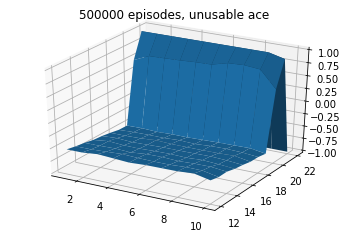

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Grab some test data.
X=np.arange(1,11)
Y=np.arange(12,23)
X, Y = np.meshgrid(X,Y)
Z=np.zeros((10,11,2))
for i in v:
  # print(i)
  Z[i[1]-1][i[0]-12][i[2]]=v[i]
# Plot a basic wireframe.
# print(X.shape,Y.shape,Z[:,:,0].shape)
ax.plot_surface(X,Y,np.transpose(Z[:,:,0]),rstride=1,cstride=1)
plt.title('500000 episodes, unusable ace')
plt.show()

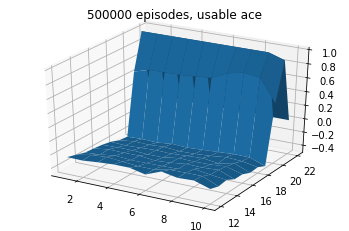

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(Z[:,:,1]),rstride=1,cstride=1)
plt.title('500000 episodes, usable ace')
plt.show()

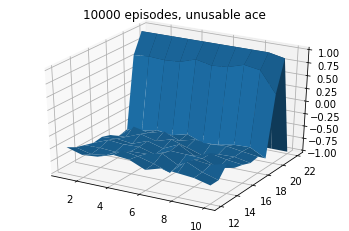

In [ ]:
for i in v_10k:
  Z[i[1]-1][i[0]-12][i[2]]=v_10k[i]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(Z[:,:,0]),rstride=1,cstride=1)
plt.title('10000 episodes, unusable ace')
plt.show()

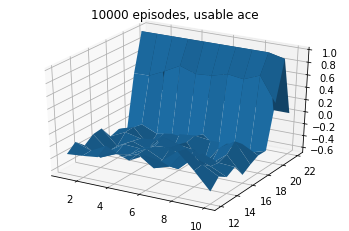

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(Z[:,:,1]),rstride=1,cstride=1)
plt.title('10000 episodes, usable ace')
plt.show()

Monte Carlo ES

In [ ]:
def get_tuple(arr):
  return tuple(arr)

In [38]:
def gen_episode_ES(s0,a0):
  dc0=s0[1]
  dc1=random.randint(1,10)
  d_ace=dc0==1 or dc1==1
  ds=dc0+dc1
  episodes=[]
  curState=s0
  action=a0
  while True:
    episodes.append([curState,action,q[get_tuple(curState)][action]])
    next_card=get_card()
    curState[0]+=next_card
    if curState[0]<20:
      action=pi[get_tuple(curState)]
    elif curState[0]==21:
      episodes.append([curState,action,q[get_tuple(curState)][action]])
      break
    elif curState[0]>21:
      if curState[2]==1:
        curState[0]-=10
        curState[2]=0
        action=pi[get_tuple(curState)]
        episodes.append([curState,action,q[get_tuple(curState)][action]])
      else:
        curState[0]=22
        episodes.append([curState,action,q[get_tuple(curState)][action]])
        break
    else:
      x=DealerTurn(ds,dc0,dc1,d_ace)
      if x==-1 or x==1:
        episodes.append([curState,1,x])
      else:
        if x==curState[0]:
          r=0
        elif x<curState[0]:
          r=1
        else:
          r=-1
        episodes.append([curState,1,r])
      break
  return episodes

In [39]:
for i in tqdm(range(total_eps)):
  S0=[random.randint(12,21),random.randint(1,10),random.randint(0,1)]
  A0=random.randint(0,1)
  episode=gen_episode_ES(S0,A0)
  # print(episode)
  # print(ep)
  G=0
  T=len(episode)
  for t in range(T-1,-1,-1):
    S_t=get_tuple(episode[t][0])
    A_t=episode[t][1]
    G+=episode[t][2]
    count_ES[S_t][A_t]+=1
    q[S_t][A_t]+=(G-q[S_t][A_t])/count_ES[S_t][A_t]
    pi[S_t]=np.argmax(q[S_t])

100%|██████████| 500000/500000 [00:29<00:00, 16793.93it/s]


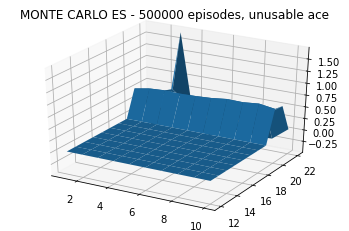

In [45]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Grab some test data.
X=np.arange(1,11)
Y=np.arange(12,23)
X, Y = np.meshgrid(X,Y)
Z=np.zeros((10,11,2))
x0=[]
y0=[]
x1=[]
y1=[]
for i in q:
  Z[i[1]-1][i[0]-12][i[2]]=max(q[i])
# Plot a basic wireframe.
# print(X.shape,Y.shape,Z[:,:,0].shape)
ax.plot_surface(X,Y,np.transpose(Z[:,:,0]),rstride=1,cstride=1)
plt.title('MONTE CARLO ES - 500000 episodes, unusable ace')
plt.show()

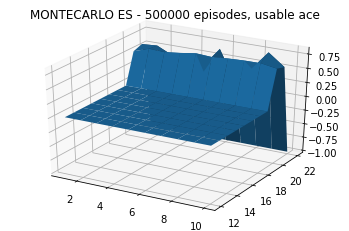

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,np.transpose(Z[:,:,1]),rstride=1,cstride=1)
plt.title('MONTECARLO ES - 500000 episodes, usable ace')
plt.show()